In [1]:
import pandas as pd
import numpy as np
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler


In [2]:
!conda install -c conda-forge folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.10.1              |             py_0          59 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTAL

Loading data from a file for the boroughs and creating a dataframe

In [5]:
# loading data from csv file and creating a dataframe
body = client_8c164c02512a4dc1a49989e9c5bfc388.get_object(Bucket='finalcapstoneproject-donotdelete-pr-lyxeutdggvvjcd',Key='London postcodes.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
df_data_4.head()


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.218257,BR,BR1,Metropolitan Police,Thames Water,9F32C228+J5,63100
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.253666,BR,BR1,Metropolitan Police,Thames Water,9F32C248+G3,56100
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,Greater London,Bromley,Bromley Town,...,1,2020-02-19,Bromley South,0.044559,BR,BR1,Metropolitan Police,NaN,9F32C228+2M,63100
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley North,0.462939,BR,BR1,Metropolitan Police,Thames Water,9F32C237+RM,63100
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,Greater London,Bromley,Bromley Town,...,0,2020-02-19,Bromley South,0.227664,BR,BR1,Metropolitan Police,Thames Water,9F32C227+HX,63100


These are the first five rows of the dataframe with all the data for each borough. WE can see that the data consist out of 47 features, out of which we need only the name of the district/borough, its latitude and longitude /for creation of map/, district code /for combining with outher data/ and average income.
Next step is to create a new dataframe with only those features as columns and get overview of the top boroughs per income.

In [6]:
# creating new dataframe with 
boroughs = df_data_4[["Postcode", "Latitude", "Longitude", "District", "District Code", "Postcode district", "Average Income"]]
boroughs.head()

,Postcode,Latitude,Longitude,District,District Code,Postcode district,Average Income
0,BR1 1AA,51.401546,0.015415,Bromley,E09000006,BR1,63100
1,BR1 1AB,51.406333,0.015208,Bromley,E09000006,BR1,56100
2,BR1 1AD,51.400057,0.016715,Bromley,E09000006,BR1,63100
3,BR1 1AE,51.404543,0.014195,Bromley,E09000006,BR1,63100
4,BR1 1AF,51.401392,0.014948,Bromley,E09000006,BR1,63100


Now we are going to get the mean values of average income per district and show the top ones:

In [7]:
# grouping data per District
boroughs1 = boroughs.groupby(['District'])['Latitude', 'Longitude', 'Average Income'].mean().reset_index()
boroughs1.sort_values("Average Income", ascending=False, inplace = True)
boroughs1.head()

,District,Latitude,Longitude,Average Income
26,Richmond upon Thames,51.449029,-0.316954,67466.133739
6,City of London,51.514287,-0.091435,65400.000000
31,Wandsworth,51.455802,-0.176793,63903.437739
23,Merton,51.411093,-0.196325,61113.184932
19,Kensington and Chelsea,51.498517,-0.187363,60401.025339


As we can see the top district based on Average Income is Richmond upon Thames.

In [8]:
boroughs2 = boroughs[["District", 'District Code', "Postcode district"]]
boroughs2.shape

(321834, 3)

Next step is to create a new dataframe adding the columns District Code and Postcodes for each borough

In [9]:
# mergin the two tables and remove duplicate post codes
boroughs_data = pd.merge(boroughs1, boroughs2, on="District")
boroughs_data.sort_values("District", inplace = True)
boroughs_data.drop_duplicates(subset="District", keep='first', inplace = True)
boroughs_data.shape

(33, 6)

Now we have 33 boroughs of London together with the data needed for further merge with the data with their profiles. So let's first load the csv file with profile information and create a new dataframe based on it:

In [10]:
# loading brough-profiles data
body = client_8c164c02512a4dc1a49989e9c5bfc388.get_object(Bucket='finalcapstoneproject-donotdelete-pr-lyxeutdggvvjcd',Key='borough-profiles.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)
df_data_5.head()


,Code,Area name,Population,Households,Area,Density,Avg Age,Most migrants,Employment rate,Unemployment rate,...,Number of active business,Crime rates,Fires rates,Median House Price,New homes,Owned homes rate,Rented homes rate,Recycling rate,Transportation accessability,Life satisfaction score
0,E09000001,City of London,8800,5326,290,30.3,43.2,United States,64.6,6.0,...,26130,0.0,12.3,799999,80,50.0,50.0,34.4,7.9,6.6
1,E09000002,Barking and Dagenham,209000,78188,"3,611",57.9,32.9,Nigeria,65.8,11.0,...,6560,83.4,3.0,243500,730,43.8,56.2,23.4,3.0,7.1
2,E09000003,Barnet,389600,151423,"8,675",44.9,37.3,India,68.5,8.5,...,26190,62.7,1.6,445000,1460,57.6,42.2,38.0,3.0,7.5
3,E09000004,Bexley,244300,97736,"6,058",40.3,39.0,Nigeria,75.1,7.6,...,9075,51.8,2.3,275000,-130,73.4,26.6,54.0,2.6,7.4
4,E09000005,Brent,332100,121048,"4,323",76.8,35.6,India,69.5,7.5,...,15745,78.8,1.8,407250,1050,44.8,55.2,35.2,3.7,7.3


We have the names and the codes of all boroughs and 22 features categorizing their profile such as: Population, Area, Density, Median House Price, Crime rates, etc, necessary for our borough analysis below. Next step is to merge our two datasets and create a new one with all features:

In [11]:
# renaming columns to merge the two tables
df_data_5.rename(columns={"Area name": "District", "Code": "District Code"}, inplace=True)


,District Code,District,Population,Households,Area,Density,Avg Age,Most migrants,Employment rate,Unemployment rate,...,Number of active business,Crime rates,Fires rates,Median House Price,New homes,Owned homes rate,Rented homes rate,Recycling rate,Transportation accessability,Life satisfaction score
0,E09000001,City of London,8800,5326,290,30.3,43.2,United States,64.6,6.0,...,26130,0.0,12.3,799999,80,50.0,50.0,34.4,7.9,6.6
1,E09000002,Barking and Dagenham,209000,78188,"3,611",57.9,32.9,Nigeria,65.8,11.0,...,6560,83.4,3.0,243500,730,43.8,56.2,23.4,3.0,7.1
2,E09000003,Barnet,389600,151423,"8,675",44.9,37.3,India,68.5,8.5,...,26190,62.7,1.6,445000,1460,57.6,42.2,38.0,3.0,7.5
3,E09000004,Bexley,244300,97736,"6,058",40.3,39.0,Nigeria,75.1,7.6,...,9075,51.8,2.3,275000,-130,73.4,26.6,54.0,2.6,7.4
4,E09000005,Brent,332100,121048,"4,323",76.8,35.6,India,69.5,7.5,...,15745,78.8,1.8,407250,1050,44.8,55.2,35.2,3.7,7.3


In [12]:
# merging the two dataframes in one based on district name
boroughs_profiles = pd.merge(boroughs_data, df_data_5, on="District")
boroughs_profiles.head()

,District,Latitude,Longitude,Average Income,District Code_x,Postcode district,District Code_y,Population,Households,Area,...,Number of active business,Crime rates,Fires rates,Median House Price,New homes,Owned homes rate,Rented homes rate,Recycling rate,Transportation accessability,Life satisfaction score
0,Barking and Dagenham,51.546468,0.124998,42598.777778,E09000002,RM9,E09000002,209000,78188,"3,611",...,6560,83.4,3.0,243500,730,43.8,56.2,23.4,3.0,7.1
1,Barnet,51.605532,-0.207715,55494.919937,E09000003,N12,E09000003,389600,151423,"8,675",...,26190,62.7,1.6,445000,1460,57.6,42.2,38.0,3.0,7.5
2,Bexley,51.459171,0.136321,50460.084892,E09000004,DA15,E09000004,244300,97736,"6,058",...,9075,51.8,2.3,275000,-130,73.4,26.6,54.0,2.6,7.4
3,Brent,51.551800,-0.257501,47929.622190,E09000005,HA9,E09000005,332100,121048,"4,323",...,15745,78.8,1.8,407250,1050,44.8,55.2,35.2,3.7,7.3
4,Bromley,51.391800,0.026393,57703.082253,E09000006,BR1,E09000006,327900,140602,"15,013",...,15695,64.1,2.3,374975,700,72.7,27.3,48.0,2.8,7.5


Here is the final dataset, from which we will use the features based on the preliminary criteria to segment and analysis of the boroughs potential for investment in house.

In [13]:
boroughs_features = boroughs_profiles[['District', 'Latitude', 'Longitude', 'Population', 'Average Income', 'Density', 'Crime rates', 'Median House Price', 'Owned homes rate', 'Employment rate', 'Transportation accessability', 'Life satisfaction score', 'Number of active business']]
boroughs_features.shape

(33, 13)

Let's analyse the housing prices from our dataset through ploting data and define the segments:

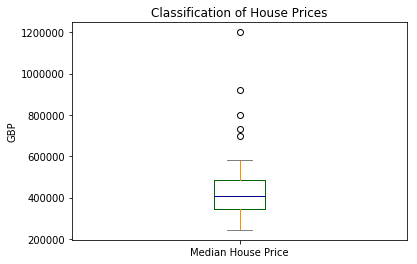

In [14]:
# plotting median housing prices 
districts = boroughs_features['District'].tolist()

prices = boroughs_features['Median House Price']
prices.plot(kind="box", color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'})
plt.title("Classification of House Prices")
plt.ylabel('GBP')
plt.show()

From the figure is shown that there are 5 pricing segments and the mean is 400 000 GBP.

In [15]:
# The median price is 400 000 GBP so based on the figure we can assume that we have 5 pricing clusters:
house_prices = pd.DataFrame({'Low':['up to 200K GBP'], 'LowerMid':['200K GBP to 400K GBP'], 'Mid': ['400K GBP'], 'HighMid': ['400K GBP - 600K GBP'], 'High': ['> 600K GBP'] }).transpose()
house_prices.rename(columns={0: 'Price ranges'}, inplace=True)
house_prices

,Price ranges
Low,up to 200K GBP
LowerMid,200K GBP to 400K GBP
Mid,400K GBP
HighMid,400K GBP - 600K GBP
High,> 600K GBP


The above figure shows the price segments and the price range.

In [16]:
# Foursqaure api credentials
CLIENT_ID = "CZIY2OCUNHWKLVCAGAZ525R1KMBWMAWZDKMS2RH3AV3JEG0V"
CLIENT_SECRET = '2DGJ3QRSGJBJ3VGHPQKOONGDIRXOZ1RU0HBVOIUCSQRY1E4D'
VERSION=20191231
LIMIT=100
RADIUS=750

In [17]:
import requests

We are going to use the Foursquare explore api to get the venues based on the coordinates of each borough in London. First will create a function with a request to the api, which will be called for each borough and the returned data will be stored in a list called venues_list, from which at the end of the funciton will be created a new Dataframe.

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
london_venues = getNearbyVenues(names=boroughs_profiles['District'],
                                   latitudes=boroughs_profiles['Latitude'],
                                   longitudes=boroughs_profiles['Longitude']
                                  )

Let's check the result returned from the function:

In [38]:
london_venues.shape

(1321, 7)

We have 1321 rows returned with 7 fetaures, which will explored further:

In [39]:
london_venues.head()

,District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.546468,0.124998,Co-op Food,51.540093,0.127522,Grocery Store
1,Barking and Dagenham,51.546468,0.124998,Parsloes Park,51.545027,0.125598,Park
2,Barking and Dagenham,51.546468,0.124998,Oak Tree Cafe,51.546869,0.114970,Café
3,Barking and Dagenham,51.546468,0.124998,Becontree London Underground Station,51.540335,0.127061,Metro Station
4,Barking and Dagenham,51.546468,0.124998,Martins Corner,51.551866,0.130512,Plaza


Will decrease the venues categories down, i.e. remove the labels of the restuarants, bars, etc and will count their frequency in our new venues dataframe.

In [40]:
# get the list of venue category
london_venues['Venue Category'] = london_venues['Venue Category'].map(lambda x: x.split(' ')[-1])
vens = london_venues['Venue Category'].value_counts()
vens.head(10)

Restaurant    294
Store         129
Shop          116
Pub            89
Bar            66
Café           64
Place          57
Park           37
Hotel          35
Center         28
Name: Venue Category, dtype: int64

Here are the top 10 frequent venues in the dataset. Down below we will show the top districts per number of venues. Only 7 of them have reached the limit of 100 venues per 500 m.

In [41]:
district_counts = london_venues.groupby('District')['Venue Category'].count().reset_index()
district_counts.sort_values("Venue Category", ascending=False, inplace = True)
counts = district_counts.reset_index()
del counts['index']

In [42]:
# all boroughs with 100 venues categories in London
counts.head(7)

,District,Venue Category
0,Westminster,100
1,Hackney,100
2,Kensington and Chelsea,100
3,Islington,100
4,Camden,100
5,City of London,100
6,Hammersmith and Fulham,100


And here are the boroughs in London with less than 10 venues per 500m:

In [43]:
# all boroughs with less than 10 Venue Categories
counts.tail(8)

,District,Venue Category
25,Ealing,9
26,Sutton,8
27,Greenwich,8
28,Kingston upon Thames,8
29,Enfield,6
30,Barking and Dagenham,5
31,Havering,5
32,Hillingdon,5


We are going to use only 7 of the venues categories: Shop, Park, Cafe, Bar, Restaurant, Theater, Pub and for those will create new columns with the number for each district.

In [44]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['District'] = london_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_all = london_onehot.groupby('District')['Shop', 'Park', 'Bar', 'Café', 'Restaurant', 'Theater', 'Pub'].sum().reset_index()
london_all.head()



,District,Shop,Park,Bar,Café,Restaurant,Theater,Pub
0,Barking and Dagenham,0,1,0,1,0,0,0
1,Barnet,0,1,0,0,0,0,0
2,Bexley,4,0,1,1,9,0,3
3,Brent,1,0,0,0,4,0,0
4,Bromley,0,1,0,1,4,0,1


Now let's visualize the data for those 7 venues categories:

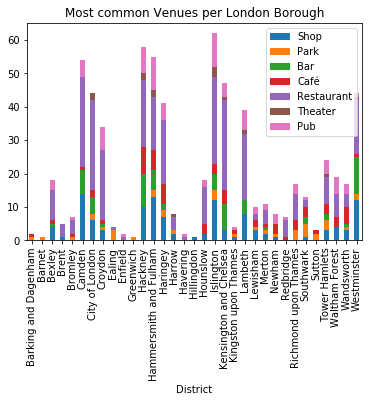

In [46]:
london_all.plot(x="District", y=['Shop', 'Park', 'Bar', 'Café', 'Restaurant', 'Theater', 'Pub'], kind='bar', stacked=True)
plt.title('Most common Venues per London Borough')
plt.legend()
plt.show()

From the figure is shown that Islington, Hackney, Camden and Hammersmith and Fullam are the top districts with large number of selected venues. Next step is to create the final dataframe combining the profiles with venues per district.

In [47]:
# combining selected borough features and most common venues per borough
london_final = pd.merge(boroughs_features, london_all, on="District")
london_final.head()

,District,Latitude,Longitude,Population,Average Income,Density,Crime rates,Median House Price,Owned homes rate,Employment rate,Transportation accessability,Life satisfaction score,Number of active business,Shop,Park,Bar,Café,Restaurant,Theater,Pub
0,Barking and Dagenham,51.546468,0.124998,209000,42598.777778,57.9,83.4,243500,43.8,65.8,3.0,7.1,6560,0,1,0,1,0,0,0
1,Barnet,51.605532,-0.207715,389600,55494.919937,44.9,62.7,445000,57.6,68.5,3.0,7.5,26190,0,1,0,0,0,0,0
2,Bexley,51.459171,0.136321,244300,50460.084892,40.3,51.8,275000,73.4,75.1,2.6,7.4,9075,4,0,1,1,9,0,3
3,Brent,51.551800,-0.257501,332100,47929.622190,76.8,78.8,407250,44.8,69.5,3.7,7.3,15745,1,0,0,0,4,0,0
4,Bromley,51.391800,0.026393,327900,57703.082253,21.8,64.1,374975,72.7,75.3,2.8,7.5,15695,0,1,0,1,4,0,1


Will use our final dataset for the clustering and therefore will perform normalizing of the data.

In [48]:
# normalizing data
X = london_final.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-7.91290656e-01, -2.21244161e+00, -4.27327759e-01,
         3.29305996e-02, -1.10302243e+00, -4.56125984e-01,
        -1.66431159e+00, -7.40669044e-01, -9.37192073e-01,
        -1.13092140e+00, -8.32574007e-01, -1.08068645e-01,
        -6.42261629e-01, -4.66389579e-01, -9.58208973e-01,
        -5.44125452e-01, -9.41179965e-01],
       [ 1.64160970e+00,  2.05241555e-01, -7.62471468e-01,
        -5.85060955e-01, -1.01711205e-01,  5.35376513e-01,
        -1.01448616e+00, -7.40669044e-01,  1.19572782e+00,
         1.12441084e+00, -8.32574007e-01, -1.08068645e-01,
        -6.42261629e-01, -9.62868808e-01, -9.58208973e-01,
        -5.44125452e-01, -9.41179965e-01],
       [-3.15756976e-01, -7.38655912e-01, -8.81060781e-01,
        -9.10476798e-01, -9.46489904e-01,  1.67057502e+00,
         5.73975994e-01, -1.05203310e+00,  6.62497845e-01,
        -8.41967725e-01,  1.14837794e-01, -9.99634970e-01,
        -3.21130814e-01, -4.66389579e-01,  9.77764258e-03,
        -5.44125452e-01,  1.0

For defining of how many clusters we need, will use the method of the Elbow point to determine the optimal number of clusters.

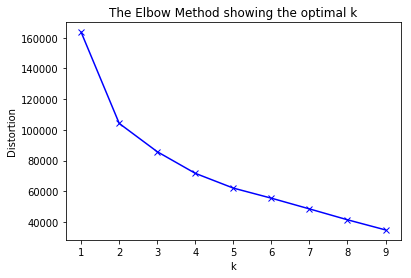

In [49]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(init = "k-means++", n_clusters=k, n_init = 12).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the figure is shown that the optimal number of clusters is 3, there fore we will create our KMeans model with number of clusters 3.

In [50]:
# Modeling
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 0 0 0 2 1 0 0 0 0 0 2 0 0 0 0 0 2 1 0 0 0 0 0 0 2 0 0 0 0 2 1]


Adding a column Clus)km with the respective cluster label generated by our model to our final dataframe:

In [52]:
london_final["Clus_km"] = labels
london_final.head()

,District,Latitude,Longitude,Population,Average Income,Density,Crime rates,Median House Price,Owned homes rate,Employment rate,...,Life satisfaction score,Number of active business,Shop,Park,Bar,Café,Restaurant,Theater,Pub,Clus_km
0,Barking and Dagenham,51.546468,0.124998,209000,42598.777778,57.9,83.4,243500,43.8,65.8,...,7.1,6560,0,1,0,1,0,0,0,0
1,Barnet,51.605532,-0.207715,389600,55494.919937,44.9,62.7,445000,57.6,68.5,...,7.5,26190,0,1,0,0,0,0,0,0
2,Bexley,51.459171,0.136321,244300,50460.084892,40.3,51.8,275000,73.4,75.1,...,7.4,9075,4,0,1,1,9,0,3,0
3,Brent,51.551800,-0.257501,332100,47929.622190,76.8,78.8,407250,44.8,69.5,...,7.3,15745,1,0,0,0,4,0,0,0
4,Bromley,51.391800,0.026393,327900,57703.082253,21.8,64.1,374975,72.7,75.3,...,7.5,15695,0,1,0,1,4,0,1,0


Creating a data with mean results per each feature for every cluster:

In [53]:
clust_stats = london_final.groupby('Clus_km').mean()
clust_stats.drop('Latitude', axis=1, inplace=True)
clust_stats.drop('Longitude', axis=1, inplace=True)
clust_stats = clust_stats.astype(int)
clust_stats

,Population,Average Income,Density,Crime rates,Median House Price,Owned homes rate,Employment rate,Transportation accessability,Life satisfaction score,Number of active business,Shop,Park,Bar,Café,Restaurant,Theater,Pub
Clus_km,,,,,,,,,,,,,,,,,
0,289928,52723,67,75,371817,52,72,3,7,13799,2,0,0,1,5,0,2
1,136633,61486,91,111,973333,38,66,6,7,31955,7,1,8,2,23,1,1
2,235460,58530,101,97,629000,46,75,4,7,20094,8,1,3,3,16,1,6


In [55]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
# streaming_body_1 = client_8c164c02512a4dc1a49989e9c5bfc388.get_object(Bucket='finalcapstoneproject-donotdelete-pr-lyxeutdggvvjcd', Key='london_boroughs_proper.geojson')['Body']
# # add missing __iter__ method so pandas accepts body as file-like object
# if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


Will use folium to show a map of district cluster.

In [57]:

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

latitude=51.5074
longitude=0.1278
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]

rainbow = ["#ff9400", "#ff0071", "#89509a9"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_final['Latitude'], london_final['Longitude'], london_final['District'], london_final['Clus_km']):
  if(math.isnan(cluster) != True):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In order to select the best borough for buying a house, we are going to take closer look at ones, that are included in the cluster number 2 of our model:

In [58]:
districts_to_choose = london_final[london_final['Clus_km'].map(lambda x: x == 2)]
districts_to_choose


,District,Latitude,Longitude,Population,Average Income,Density,Crime rates,Median House Price,Owned homes rate,Employment rate,...,Life satisfaction score,Number of active business,Shop,Park,Bar,Café,Restaurant,Theater,Pub,Clus_km
5,Camden,51.534370,-0.143292,242500,51013.145423,111.3,123.5,700000,33.6,69.2,...,7.1,31385,14,0,7,1,27,0,5,2
12,Hammersmith and Fulham,51.492079,-0.216469,185300,55715.713485,113.0,113.2,730000,40.9,77.5,...,7.4,14095,13,2,6,6,16,2,10,2
18,Islington,51.538980,-0.108733,231200,54554.998097,155.6,121.2,583000,38.9,72.6,...,7.2,22110,12,3,5,3,26,3,10,2
26,Richmond upon Thames,51.449029,-0.316954,197300,67466.133739,34.4,56.3,575000,69.3,79.6,...,7.5,14185,0,3,0,3,8,0,3,2
31,Wandsworth,51.455802,-0.176793,321000,63903.437739,93.7,72.6,557000,48.2,78.8,...,7.4,18695,3,1,1,5,4,0,3,2


Here are the 5 districts under cluster number 2. The first 3 of them have the high number of venues, but also a high Crime rates. From the last two districts, Richmond uppon Thames has lower Crime rate, high percentage of owned homes and employment rate. Also this is the district with the highest Life satisfaction score, therefore this is the recommended district to invest in house for a mid class household.